# Nornikel Hackathon, Multimodal RAG: Introduction

In [2]:
!pip install pytesseract
!pip install PyPDF2
!pip install python-pptx
!pip install python-docx
!pip install elasticsearch
!pip install sentence_transformers
!pip install fastapi
!pip install pydantic
!pip install fitz
!pip install PyMuPDF
!pip install pdfplumber
print ("Done")

Done


In [3]:
import os
import torch
import pytesseract
from PyPDF2 import PdfReader
from PIL import Image
from pptx import Presentation
import docx
from datetime import datetime
from elasticsearch import Elasticsearch
from sentence_transformers import SentenceTransformer
import os
import json
from fastapi import FastAPI, Query
from pydantic import BaseModel
from elasticsearch import Elasticsearch
from sentence_transformers import SentenceTransformer
import warnings
import sys
import fitz
import pdfplumber
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
print ("Done")

Done


In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

if not sys.warnoptions:
    warnings.simplefilter("ignore")

print ("Done")

Done


### Распаковка архива в папку dataset

In [5]:
import zipfile

os.makedirs('./dataset', exist_ok=True)

with zipfile.ZipFile('RAG.zip', 'r') as zip_ref:
    zip_ref.extractall('./dataset')

DATASET_PATH = "dataset"
print ("Done")

Done


# Necessary EDA (Exploratory data analysis)

Общее количество файлов: 33
Распределение по типам файлов: {'PDF': 28, 'Word': 5}
Средняя длина текста: 244242.97 символов
Среднее количество изображений на файл: 84.33


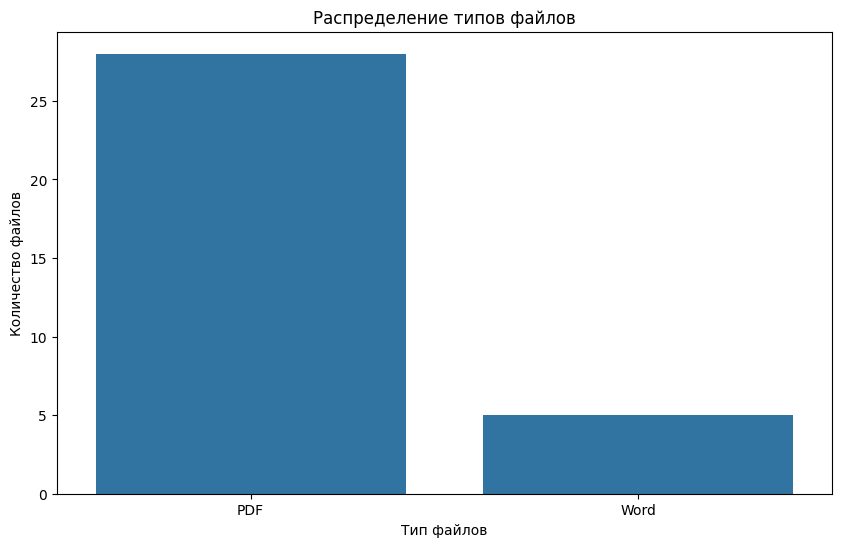

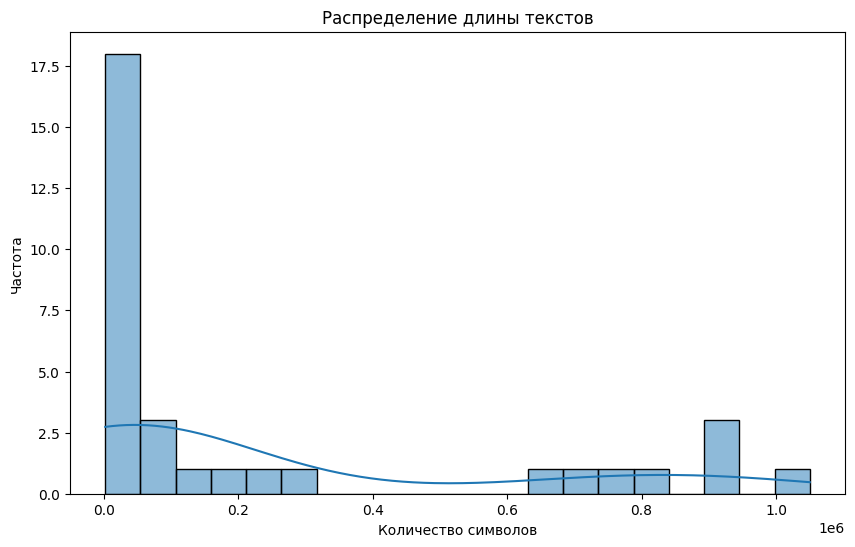

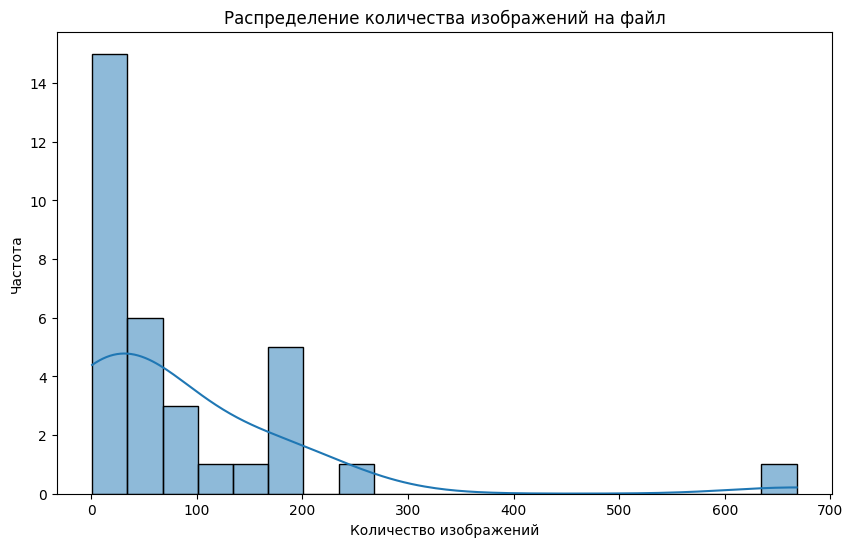

Done


In [6]:
stats = {
    "total_files": 0,
    "file_types": Counter(),
    "text_lengths": [],
    "images_per_file": [],
    "tables_detected": 0
}

# Функция для анализа PDF
def analyze_pdf(file_path):
    text_length = 0
    image_count = 0
    
    # Открываем PDF
    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            # Извлечение текста
            text_length += len(page.extract_text() or "")
            
            # Извлечение изображений
            for image in page.images:
                image_count += 1

    stats["text_lengths"].append(text_length)
    stats["images_per_file"].append(image_count)

# Функция для анализа Word
def analyze_word(file_path):
    doc = docx.Document(file_path)
    text_length = 0
    image_count = 0
    
    for para in doc.paragraphs:
        text_length += len(para.text)
    
    for rel in doc.part.rels.values():
        if "image" in rel.target_ref:
            image_count += 1

    stats["text_lengths"].append(text_length)
    stats["images_per_file"].append(image_count)

# Визуализация статистики
def plot_statistics():
    # Типы файлов
    file_types = stats["file_types"]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(file_types.keys()), y=list(file_types.values()))
    plt.title("Распределение типов файлов")
    plt.ylabel("Количество файлов")
    plt.xlabel("Тип файлов")
    plt.show()

    # Длина текста
    plt.figure(figsize=(10, 6))
    sns.histplot(stats["text_lengths"], bins=20, kde=True)
    plt.title("Распределение длины текстов")
    plt.xlabel("Количество символов")
    plt.ylabel("Частота")
    plt.show()

    # Количество изображений
    plt.figure(figsize=(10, 6))
    sns.histplot(stats["images_per_file"], bins=20, kde=True)
    plt.title("Распределение количества изображений на файл")
    plt.xlabel("Количество изображений")
    plt.ylabel("Частота")
    plt.show()

# Вывод статистики
def print_statistics():
    print(f"Общее количество файлов: {stats['total_files']}")
    print(f"Распределение по типам файлов: {dict(stats['file_types'])}")
    print(f"Средняя длина текста: {sum(stats['text_lengths']) / len(stats['text_lengths']):.2f} символов")
    print(f"Среднее количество изображений на файл: {sum(stats['images_per_file']) / len(stats['images_per_file']):.2f}")

if __name__ == "__main__":
    for root, _, files in os.walk(DATASET_PATH):
        for file in files:
            file_path = os.path.join(root, file)
            stats["total_files"] += 1
            
            # Определяем тип файла
            if file.endswith(".pdf"):
                stats["file_types"]["PDF"] += 1
                analyze_pdf(file_path)
            elif file.endswith(".docx"):
                stats["file_types"]["Word"] += 1
                analyze_word(file_path)
            else:
                stats["file_types"]["Other"] += 1

    print_statistics()
    plot_statistics()

print ("Done")